In [1]:
!pip3 install torch torchvision

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

torch.Size([27000, 1, 40, 168]) torch.Size([27000])


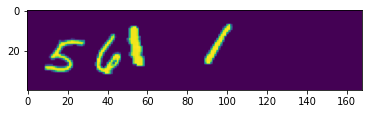

In [67]:
data_files = ['data0.npy', 'data1.npy', 'data2.npy']
label_files = ['lab0.npy', 'lab1.npy', 'lab2.npy']

data = np.load('data0.npy')
data = np.append(data, np.load('data1.npy'), axis=0)
data = np.append(data, np.load('data2.npy'), axis=0)
data = np.array([[i] for i in data])
data = torch.from_numpy(data.astype(np.float32))

labels = np.load('lab0.npy')
labels = np.append(labels, np.load('lab1.npy'), axis=0)
labels = np.append(labels, np.load('lab2.npy'), axis=0)
labels = torch.from_numpy(labels.astype(np.long))
    
train_data = data[:27000]
train_labels = labels[:27000]

test_data = data[27000:]
test_labels = labels[27000:]

print(train_data.shape, train_labels.shape)
i = 1
plt.imshow(test_data[i][0])

In [68]:
BATCH_SIZE = 32

trainset = torch.utils.data.TensorDataset(train_data,train_labels)
testset = torch.utils.data.TensorDataset(test_data,test_labels)

trainset, valset = torch.utils.data.random_split(trainset, [int(0.8 * len(trainset)), int(0.2 * len(trainset))])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


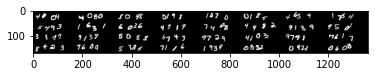

In [69]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
## show images
imshow(torchvision.utils.make_grid(images))

In [70]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 40, 168])
Image label dimensions: torch.Size([32])


In [71]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = nn.Linear(40 * 168 * 1, 2000)
        self.d2 = nn.Linear(2000, 1000)
        self.d3 = nn.Linear(1000, 500)
        self.d4 = nn.Linear(500, 37)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)
        x = self.d2(x)
        x = F.relu(x)
        x = self.d3(x)
        x = F.relu(x)
        logits = self.d4(x)
        out = F.softmax(logits, dim=1)
        
        return out

In [72]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 40, 168])
torch.Size([32, 37])


In [74]:
learning_rate = 0.00001
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [76]:
train_loss = list()
val_loss = list()
train_acc = list()
val_acc = list()

for epoch in tqdm(range(num_epochs)):
    total_train_loss = 0
    total_val_loss = 0

    total_train_acc = 0.0
    total_val_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        pred = model(images)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        total_train_loss += loss.detach().item()
        total_train_acc += get_accuracy(pred, labels, BATCH_SIZE)
    
    total_train_loss = total_train_loss/i
    total_train_acc = total_train_acc/i
    train_loss.append(total_train_loss)
    train_acc.append(total_train_acc)

    model.eval()

    ## validation step
    for i, (images, labels) in enumerate(valloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        pred = model(images)
        loss = criterion(pred, labels)

        total_val_loss += loss.detach().item()
        total_val_acc += get_accuracy(pred, labels, BATCH_SIZE)

    total_val_loss = total_val_loss/i
    total_val_acc = total_val_acc/i
    val_loss.append(total_val_loss)
    val_acc.append(total_val_acc)

    print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.2f | Val Loss: %.4f | Val Accuracy: %.2f' %(epoch, total_train_loss, total_train_acc, total_val_loss, total_val_acc )) 



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:07<12:20,  7.48s/it]

Epoch: 0 | Train Loss: 3.5976 | Train Accuracy: 6.38 | Val Loss: 3.6093 | Val Accuracy: 6.68




  2%|▏         | 2/100 [00:14<12:08,  7.44s/it]

Epoch: 1 | Train Loss: 3.5933 | Train Accuracy: 6.62 | Val Loss: 3.6121 | Val Accuracy: 6.49




  3%|▎         | 3/100 [00:22<11:56,  7.39s/it]

Epoch: 2 | Train Loss: 3.5780 | Train Accuracy: 7.94 | Val Loss: 3.6086 | Val Accuracy: 6.51




  4%|▍         | 4/100 [00:29<11:48,  7.38s/it]

Epoch: 3 | Train Loss: 3.5445 | Train Accuracy: 11.45 | Val Loss: 3.6072 | Val Accuracy: 6.44




  5%|▌         | 5/100 [00:36<11:42,  7.40s/it]

Epoch: 4 | Train Loss: 3.4946 | Train Accuracy: 17.09 | Val Loss: 3.6047 | Val Accuracy: 6.47




  6%|▌         | 6/100 [00:44<11:35,  7.40s/it]

Epoch: 5 | Train Loss: 3.4398 | Train Accuracy: 22.91 | Val Loss: 3.6047 | Val Accuracy: 6.08




  7%|▋         | 7/100 [00:51<11:33,  7.45s/it]

Epoch: 6 | Train Loss: 3.3914 | Train Accuracy: 27.63 | Val Loss: 3.6037 | Val Accuracy: 6.21




  8%|▊         | 8/100 [00:59<11:23,  7.43s/it]

Epoch: 7 | Train Loss: 3.3521 | Train Accuracy: 31.53 | Val Loss: 3.6039 | Val Accuracy: 6.57




  9%|▉         | 9/100 [01:06<11:16,  7.44s/it]

Epoch: 8 | Train Loss: 3.3145 | Train Accuracy: 35.26 | Val Loss: 3.6044 | Val Accuracy: 6.12




 10%|█         | 10/100 [01:14<11:07,  7.41s/it]

Epoch: 9 | Train Loss: 3.2773 | Train Accuracy: 39.15 | Val Loss: 3.6047 | Val Accuracy: 6.40




 11%|█         | 11/100 [01:21<11:00,  7.42s/it]

Epoch: 10 | Train Loss: 3.2355 | Train Accuracy: 43.61 | Val Loss: 3.6057 | Val Accuracy: 6.10




 12%|█▏        | 12/100 [01:28<10:51,  7.40s/it]

Epoch: 11 | Train Loss: 3.1928 | Train Accuracy: 47.98 | Val Loss: 3.6063 | Val Accuracy: 6.05




 13%|█▎        | 13/100 [01:36<10:44,  7.41s/it]

Epoch: 12 | Train Loss: 3.1554 | Train Accuracy: 51.51 | Val Loss: 3.6051 | Val Accuracy: 6.06




 14%|█▍        | 14/100 [01:43<10:33,  7.37s/it]

Epoch: 13 | Train Loss: 3.1249 | Train Accuracy: 54.22 | Val Loss: 3.6083 | Val Accuracy: 5.64




 15%|█▌        | 15/100 [01:50<10:27,  7.38s/it]

Epoch: 14 | Train Loss: 3.1011 | Train Accuracy: 56.64 | Val Loss: 3.6094 | Val Accuracy: 5.51




 16%|█▌        | 16/100 [01:58<10:20,  7.38s/it]

Epoch: 15 | Train Loss: 3.0786 | Train Accuracy: 58.69 | Val Loss: 3.6078 | Val Accuracy: 6.03




 17%|█▋        | 17/100 [02:05<10:14,  7.40s/it]

Epoch: 16 | Train Loss: 3.0615 | Train Accuracy: 60.40 | Val Loss: 3.6089 | Val Accuracy: 5.62




 18%|█▊        | 18/100 [02:13<10:06,  7.40s/it]

Epoch: 17 | Train Loss: 3.0448 | Train Accuracy: 62.37 | Val Loss: 3.6095 | Val Accuracy: 5.90




 19%|█▉        | 19/100 [02:20<10:01,  7.42s/it]

Epoch: 18 | Train Loss: 3.0200 | Train Accuracy: 64.82 | Val Loss: 3.6084 | Val Accuracy: 5.88




 20%|██        | 20/100 [02:28<09:53,  7.42s/it]

Epoch: 19 | Train Loss: 2.9970 | Train Accuracy: 67.03 | Val Loss: 3.6087 | Val Accuracy: 5.93




 21%|██        | 21/100 [02:35<09:45,  7.41s/it]

Epoch: 20 | Train Loss: 2.9802 | Train Accuracy: 68.56 | Val Loss: 3.6088 | Val Accuracy: 6.08




 22%|██▏       | 22/100 [02:42<09:35,  7.38s/it]

Epoch: 21 | Train Loss: 2.9662 | Train Accuracy: 69.79 | Val Loss: 3.6101 | Val Accuracy: 5.71




 23%|██▎       | 23/100 [02:50<09:26,  7.36s/it]

Epoch: 22 | Train Loss: 2.9556 | Train Accuracy: 70.74 | Val Loss: 3.6130 | Val Accuracy: 5.62




 24%|██▍       | 24/100 [02:57<09:18,  7.35s/it]

Epoch: 23 | Train Loss: 2.9467 | Train Accuracy: 71.58 | Val Loss: 3.6105 | Val Accuracy: 5.75




 25%|██▌       | 25/100 [03:04<09:11,  7.35s/it]

Epoch: 24 | Train Loss: 2.9400 | Train Accuracy: 72.32 | Val Loss: 3.6112 | Val Accuracy: 5.84




 26%|██▌       | 26/100 [03:12<09:03,  7.35s/it]

Epoch: 25 | Train Loss: 2.9320 | Train Accuracy: 73.19 | Val Loss: 3.6091 | Val Accuracy: 5.92




 27%|██▋       | 27/100 [03:19<08:57,  7.36s/it]

Epoch: 26 | Train Loss: 2.9213 | Train Accuracy: 74.43 | Val Loss: 3.6108 | Val Accuracy: 5.80




 28%|██▊       | 28/100 [03:26<08:51,  7.38s/it]

Epoch: 27 | Train Loss: 2.9074 | Train Accuracy: 75.79 | Val Loss: 3.6110 | Val Accuracy: 5.78




 29%|██▉       | 29/100 [03:34<08:43,  7.37s/it]

Epoch: 28 | Train Loss: 2.8956 | Train Accuracy: 76.81 | Val Loss: 3.6129 | Val Accuracy: 5.60




 30%|███       | 30/100 [03:41<08:37,  7.39s/it]

Epoch: 29 | Train Loss: 2.8873 | Train Accuracy: 77.67 | Val Loss: 3.6130 | Val Accuracy: 5.34




 31%|███       | 31/100 [03:49<08:28,  7.37s/it]

Epoch: 30 | Train Loss: 2.8798 | Train Accuracy: 78.38 | Val Loss: 3.6109 | Val Accuracy: 5.64




 32%|███▏      | 32/100 [03:56<08:18,  7.33s/it]

Epoch: 31 | Train Loss: 2.8699 | Train Accuracy: 79.38 | Val Loss: 3.6188 | Val Accuracy: 4.89




 33%|███▎      | 33/100 [04:03<08:10,  7.32s/it]

Epoch: 32 | Train Loss: 2.8616 | Train Accuracy: 80.30 | Val Loss: 3.6171 | Val Accuracy: 4.85




 34%|███▍      | 34/100 [04:10<08:04,  7.33s/it]

Epoch: 33 | Train Loss: 2.8532 | Train Accuracy: 81.02 | Val Loss: 3.6191 | Val Accuracy: 4.72




 35%|███▌      | 35/100 [04:18<07:55,  7.32s/it]

Epoch: 34 | Train Loss: 2.8465 | Train Accuracy: 81.79 | Val Loss: 3.6137 | Val Accuracy: 5.65




 36%|███▌      | 36/100 [04:25<07:49,  7.33s/it]

Epoch: 35 | Train Loss: 2.8374 | Train Accuracy: 82.63 | Val Loss: 3.6183 | Val Accuracy: 5.15




 37%|███▋      | 37/100 [04:32<07:39,  7.30s/it]

Epoch: 36 | Train Loss: 2.8310 | Train Accuracy: 83.23 | Val Loss: 3.6168 | Val Accuracy: 5.34




 38%|███▊      | 38/100 [04:40<07:32,  7.30s/it]

Epoch: 37 | Train Loss: 2.8240 | Train Accuracy: 83.84 | Val Loss: 3.6161 | Val Accuracy: 5.47




 39%|███▉      | 39/100 [04:47<07:28,  7.35s/it]

Epoch: 38 | Train Loss: 2.8201 | Train Accuracy: 84.28 | Val Loss: 3.6173 | Val Accuracy: 5.15




 40%|████      | 40/100 [04:55<07:24,  7.41s/it]

Epoch: 39 | Train Loss: 2.8163 | Train Accuracy: 84.75 | Val Loss: 3.6154 | Val Accuracy: 5.30




 41%|████      | 41/100 [05:02<07:16,  7.40s/it]

Epoch: 40 | Train Loss: 2.8128 | Train Accuracy: 85.02 | Val Loss: 3.6153 | Val Accuracy: 5.51




 42%|████▏     | 42/100 [05:09<07:09,  7.41s/it]

Epoch: 41 | Train Loss: 2.8091 | Train Accuracy: 85.38 | Val Loss: 3.6188 | Val Accuracy: 5.12




 43%|████▎     | 43/100 [05:17<07:02,  7.41s/it]

Epoch: 42 | Train Loss: 2.8049 | Train Accuracy: 85.73 | Val Loss: 3.6169 | Val Accuracy: 5.28




 44%|████▍     | 44/100 [05:24<06:54,  7.40s/it]

Epoch: 43 | Train Loss: 2.8021 | Train Accuracy: 86.06 | Val Loss: 3.6167 | Val Accuracy: 5.34




 45%|████▌     | 45/100 [05:32<06:46,  7.38s/it]

Epoch: 44 | Train Loss: 2.7998 | Train Accuracy: 86.36 | Val Loss: 3.6157 | Val Accuracy: 5.47




 46%|████▌     | 46/100 [05:39<06:37,  7.37s/it]

Epoch: 45 | Train Loss: 2.7948 | Train Accuracy: 86.73 | Val Loss: 3.6165 | Val Accuracy: 5.34




 47%|████▋     | 47/100 [05:46<06:28,  7.33s/it]

Epoch: 46 | Train Loss: 2.7922 | Train Accuracy: 87.06 | Val Loss: 3.6200 | Val Accuracy: 4.76




 48%|████▊     | 48/100 [05:54<06:23,  7.37s/it]

Epoch: 47 | Train Loss: 2.7885 | Train Accuracy: 87.47 | Val Loss: 3.6186 | Val Accuracy: 5.04




 49%|████▉     | 49/100 [06:01<06:17,  7.40s/it]

Epoch: 48 | Train Loss: 2.7841 | Train Accuracy: 87.86 | Val Loss: 3.6189 | Val Accuracy: 5.21




 50%|█████     | 50/100 [06:08<06:08,  7.36s/it]

Epoch: 49 | Train Loss: 2.7804 | Train Accuracy: 88.20 | Val Loss: 3.6202 | Val Accuracy: 4.72




 51%|█████     | 51/100 [06:16<05:59,  7.33s/it]

Epoch: 50 | Train Loss: 2.7769 | Train Accuracy: 88.57 | Val Loss: 3.6194 | Val Accuracy: 5.10




 52%|█████▏    | 52/100 [06:23<05:51,  7.32s/it]

Epoch: 51 | Train Loss: 2.7737 | Train Accuracy: 88.81 | Val Loss: 3.6172 | Val Accuracy: 5.06




 53%|█████▎    | 53/100 [06:30<05:45,  7.34s/it]

Epoch: 52 | Train Loss: 2.7732 | Train Accuracy: 88.94 | Val Loss: 3.6162 | Val Accuracy: 5.56




 54%|█████▍    | 54/100 [06:38<05:37,  7.34s/it]

Epoch: 53 | Train Loss: 2.7713 | Train Accuracy: 89.23 | Val Loss: 3.6201 | Val Accuracy: 5.15




 55%|█████▌    | 55/100 [06:45<05:30,  7.35s/it]

Epoch: 54 | Train Loss: 2.7664 | Train Accuracy: 89.55 | Val Loss: 3.6197 | Val Accuracy: 5.13




 56%|█████▌    | 56/100 [06:52<05:22,  7.33s/it]

Epoch: 55 | Train Loss: 2.7645 | Train Accuracy: 89.77 | Val Loss: 3.6170 | Val Accuracy: 5.38




 57%|█████▋    | 57/100 [07:00<05:15,  7.34s/it]

Epoch: 56 | Train Loss: 2.7647 | Train Accuracy: 89.85 | Val Loss: 3.6171 | Val Accuracy: 5.36




 58%|█████▊    | 58/100 [07:07<05:07,  7.31s/it]

Epoch: 57 | Train Loss: 2.7622 | Train Accuracy: 90.10 | Val Loss: 3.6186 | Val Accuracy: 5.15




 59%|█████▉    | 59/100 [07:14<05:00,  7.33s/it]

Epoch: 58 | Train Loss: 2.7586 | Train Accuracy: 90.29 | Val Loss: 3.6172 | Val Accuracy: 5.17




 60%|██████    | 60/100 [07:22<04:53,  7.33s/it]

Epoch: 59 | Train Loss: 2.7566 | Train Accuracy: 90.47 | Val Loss: 3.6180 | Val Accuracy: 5.04




 61%|██████    | 61/100 [07:29<04:47,  7.38s/it]

Epoch: 60 | Train Loss: 2.7579 | Train Accuracy: 90.44 | Val Loss: 3.6194 | Val Accuracy: 4.93




 62%|██████▏   | 62/100 [07:36<04:39,  7.36s/it]

Epoch: 61 | Train Loss: 2.7584 | Train Accuracy: 90.54 | Val Loss: 3.6185 | Val Accuracy: 5.30




 63%|██████▎   | 63/100 [07:44<04:32,  7.36s/it]

Epoch: 62 | Train Loss: 2.7539 | Train Accuracy: 90.80 | Val Loss: 3.6175 | Val Accuracy: 5.15




 64%|██████▍   | 64/100 [07:51<04:25,  7.37s/it]

Epoch: 63 | Train Loss: 2.7520 | Train Accuracy: 90.93 | Val Loss: 3.6194 | Val Accuracy: 5.04




 65%|██████▌   | 65/100 [07:59<04:18,  7.38s/it]

Epoch: 64 | Train Loss: 2.7511 | Train Accuracy: 91.01 | Val Loss: 3.6144 | Val Accuracy: 5.82




 66%|██████▌   | 66/100 [08:06<04:10,  7.36s/it]

Epoch: 65 | Train Loss: 2.7545 | Train Accuracy: 90.93 | Val Loss: 3.6190 | Val Accuracy: 5.19




 67%|██████▋   | 67/100 [08:13<04:02,  7.34s/it]

Epoch: 66 | Train Loss: 2.7507 | Train Accuracy: 91.19 | Val Loss: 3.6190 | Val Accuracy: 5.17




 68%|██████▊   | 68/100 [08:20<03:53,  7.31s/it]

Epoch: 67 | Train Loss: 2.7484 | Train Accuracy: 91.29 | Val Loss: 3.6183 | Val Accuracy: 5.25




 69%|██████▉   | 69/100 [08:28<03:46,  7.30s/it]

Epoch: 68 | Train Loss: 2.7471 | Train Accuracy: 91.41 | Val Loss: 3.6193 | Val Accuracy: 5.17




 70%|███████   | 70/100 [08:35<03:39,  7.31s/it]

Epoch: 69 | Train Loss: 2.7504 | Train Accuracy: 91.29 | Val Loss: 3.6166 | Val Accuracy: 5.43




 71%|███████   | 71/100 [08:42<03:32,  7.33s/it]

Epoch: 70 | Train Loss: 2.7486 | Train Accuracy: 91.44 | Val Loss: 3.6174 | Val Accuracy: 5.45




 72%|███████▏  | 72/100 [08:50<03:27,  7.42s/it]

Epoch: 71 | Train Loss: 2.7453 | Train Accuracy: 91.58 | Val Loss: 3.6189 | Val Accuracy: 5.15




 73%|███████▎  | 73/100 [08:57<03:18,  7.37s/it]

Epoch: 72 | Train Loss: 2.7445 | Train Accuracy: 91.67 | Val Loss: 3.6181 | Val Accuracy: 5.25




 74%|███████▍  | 74/100 [09:05<03:11,  7.36s/it]

Epoch: 73 | Train Loss: 2.7480 | Train Accuracy: 91.55 | Val Loss: 3.6220 | Val Accuracy: 4.89




 75%|███████▌  | 75/100 [09:12<03:03,  7.36s/it]

Epoch: 74 | Train Loss: 2.7446 | Train Accuracy: 91.78 | Val Loss: 3.6205 | Val Accuracy: 5.04




 76%|███████▌  | 76/100 [09:19<02:56,  7.36s/it]

Epoch: 75 | Train Loss: 2.7426 | Train Accuracy: 91.86 | Val Loss: 3.6221 | Val Accuracy: 4.87




 77%|███████▋  | 77/100 [09:27<02:48,  7.35s/it]

Epoch: 76 | Train Loss: 2.7420 | Train Accuracy: 91.90 | Val Loss: 3.6216 | Val Accuracy: 4.82




 78%|███████▊  | 78/100 [09:34<02:41,  7.33s/it]

Epoch: 77 | Train Loss: 2.7447 | Train Accuracy: 91.86 | Val Loss: 3.6170 | Val Accuracy: 5.43




 79%|███████▉  | 79/100 [09:41<02:33,  7.33s/it]

Epoch: 78 | Train Loss: 2.7414 | Train Accuracy: 92.04 | Val Loss: 3.6178 | Val Accuracy: 5.38




 80%|████████  | 80/100 [09:49<02:26,  7.30s/it]

Epoch: 79 | Train Loss: 2.7409 | Train Accuracy: 92.08 | Val Loss: 3.6152 | Val Accuracy: 5.67




 81%|████████  | 81/100 [09:56<02:19,  7.32s/it]

Epoch: 80 | Train Loss: 2.7401 | Train Accuracy: 92.12 | Val Loss: 3.6201 | Val Accuracy: 5.00




 82%|████████▏ | 82/100 [10:03<02:12,  7.39s/it]

Epoch: 81 | Train Loss: 2.7406 | Train Accuracy: 92.15 | Val Loss: 3.6175 | Val Accuracy: 5.41




 83%|████████▎ | 83/100 [10:11<02:05,  7.41s/it]

Epoch: 82 | Train Loss: 2.7419 | Train Accuracy: 92.12 | Val Loss: 3.6152 | Val Accuracy: 5.75




 84%|████████▍ | 84/100 [10:18<01:58,  7.39s/it]

Epoch: 83 | Train Loss: 2.7394 | Train Accuracy: 92.28 | Val Loss: 3.6153 | Val Accuracy: 5.78




 85%|████████▌ | 85/100 [10:26<01:50,  7.36s/it]

Epoch: 84 | Train Loss: 2.7379 | Train Accuracy: 92.38 | Val Loss: 3.6182 | Val Accuracy: 5.23




 86%|████████▌ | 86/100 [10:33<01:42,  7.33s/it]

Epoch: 85 | Train Loss: 2.7368 | Train Accuracy: 92.41 | Val Loss: 3.6197 | Val Accuracy: 5.08




 87%|████████▋ | 87/100 [10:40<01:35,  7.37s/it]

Epoch: 86 | Train Loss: 2.7372 | Train Accuracy: 92.43 | Val Loss: 3.6161 | Val Accuracy: 5.47




 88%|████████▊ | 88/100 [10:48<01:28,  7.37s/it]

Epoch: 87 | Train Loss: 2.7404 | Train Accuracy: 92.31 | Val Loss: 3.6184 | Val Accuracy: 5.28




 89%|████████▉ | 89/100 [10:55<01:21,  7.39s/it]

Epoch: 88 | Train Loss: 2.7373 | Train Accuracy: 92.52 | Val Loss: 3.6163 | Val Accuracy: 5.43




 90%|█████████ | 90/100 [11:02<01:13,  7.40s/it]

Epoch: 89 | Train Loss: 2.7352 | Train Accuracy: 92.62 | Val Loss: 3.6168 | Val Accuracy: 5.30




 91%|█████████ | 91/100 [11:10<01:06,  7.44s/it]

Epoch: 90 | Train Loss: 2.7343 | Train Accuracy: 92.67 | Val Loss: 3.6172 | Val Accuracy: 5.36




 92%|█████████▏| 92/100 [11:17<00:59,  7.41s/it]

Epoch: 91 | Train Loss: 2.7339 | Train Accuracy: 92.72 | Val Loss: 3.6179 | Val Accuracy: 5.19




 93%|█████████▎| 93/100 [11:25<00:51,  7.36s/it]

Epoch: 92 | Train Loss: 2.7393 | Train Accuracy: 92.42 | Val Loss: 3.6179 | Val Accuracy: 5.41




 94%|█████████▍| 94/100 [11:32<00:44,  7.34s/it]

Epoch: 93 | Train Loss: 2.7338 | Train Accuracy: 92.80 | Val Loss: 3.6188 | Val Accuracy: 5.26




 95%|█████████▌| 95/100 [11:39<00:36,  7.33s/it]

Epoch: 94 | Train Loss: 2.7327 | Train Accuracy: 92.84 | Val Loss: 3.6195 | Val Accuracy: 5.04




 96%|█████████▌| 96/100 [11:47<00:29,  7.34s/it]

Epoch: 95 | Train Loss: 2.7322 | Train Accuracy: 92.90 | Val Loss: 3.6199 | Val Accuracy: 4.99




 97%|█████████▋| 97/100 [11:54<00:21,  7.33s/it]

Epoch: 96 | Train Loss: 2.7354 | Train Accuracy: 92.78 | Val Loss: 3.6194 | Val Accuracy: 5.17




 98%|█████████▊| 98/100 [12:01<00:14,  7.35s/it]

Epoch: 97 | Train Loss: 2.7341 | Train Accuracy: 92.85 | Val Loss: 3.6192 | Val Accuracy: 5.04




 99%|█████████▉| 99/100 [12:09<00:07,  7.38s/it]

Epoch: 98 | Train Loss: 2.7317 | Train Accuracy: 93.01 | Val Loss: 3.6176 | Val Accuracy: 5.28




100%|██████████| 100/100 [12:16<00:00,  7.37s/it]

Epoch: 99 | Train Loss: 2.7304 | Train Accuracy: 93.06 | Val Loss: 3.6200 | Val Accuracy: 5.21


In [77]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 4.64


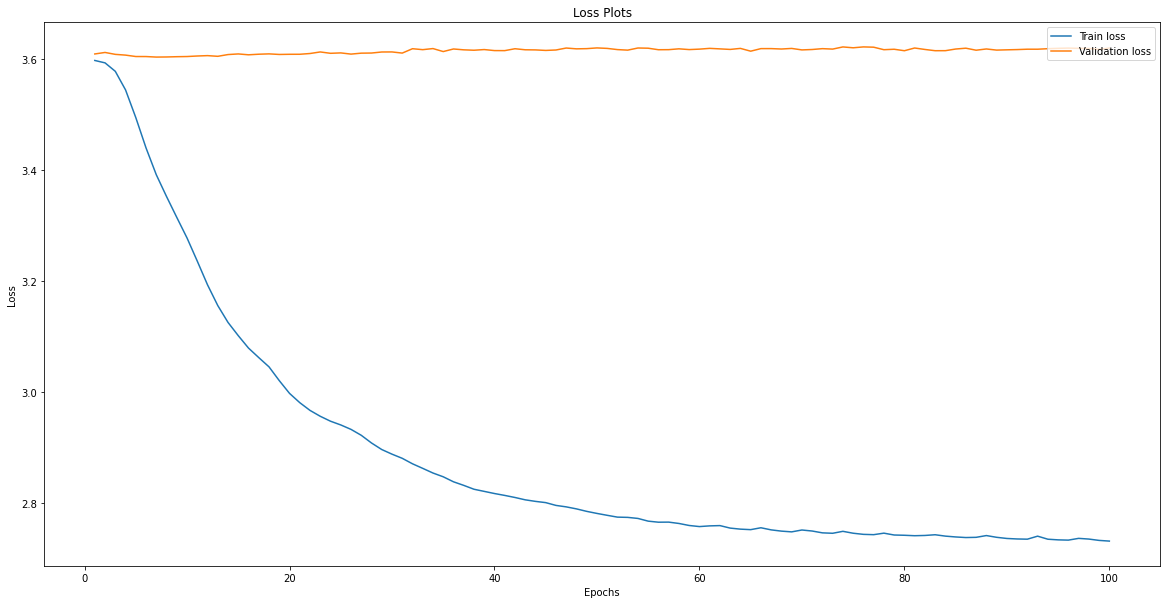

In [78]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, num_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, num_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()
# plt.savefig('loss.png')

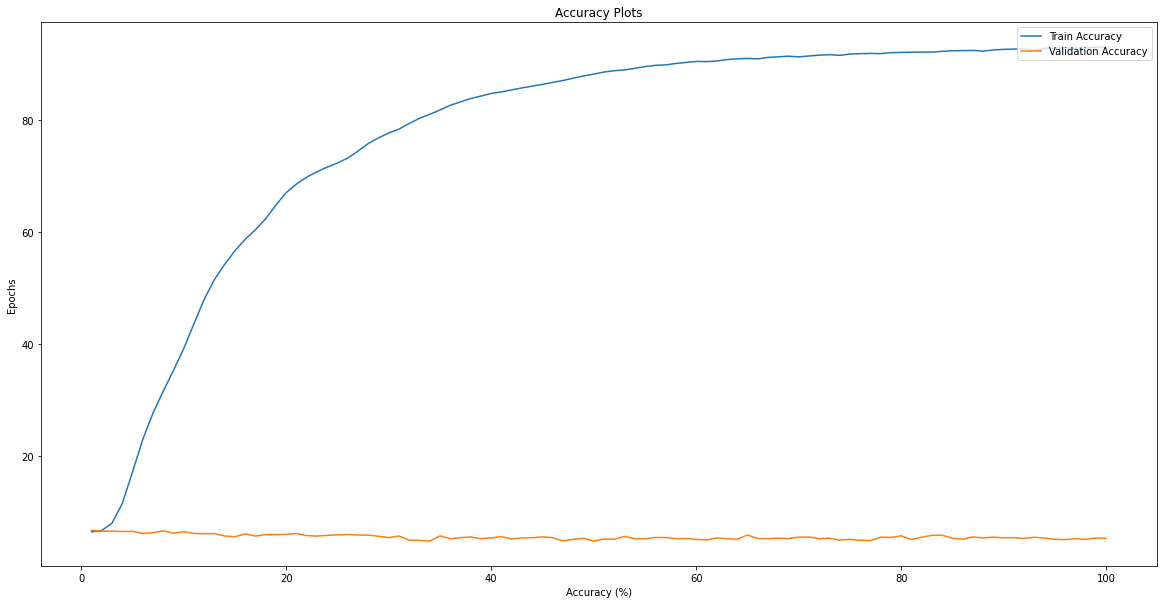

In [80]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, num_epochs+1), train_acc, label="Train Accuracy")
plt.plot(np.arange(1, num_epochs+1), val_acc, label="Validation Accuracy")
plt.xlabel('Accuracy (%)')
plt.ylabel('Epochs')
plt.title("Accuracy Plots")
plt.legend(loc='upper right')
plt.show()

In [81]:
torch.save(model, './model.zip')